In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML


display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, _scipy, ensure_np_array
import efc_2dm 
import utils
from imshows import *

data_dir = efc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = fits.getdata('spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata('spc_wide_band4_flattened_dm2.fits')

import copy



INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2024-01-09 15:47:16,744	INFO worker.py:1636 -- Started a local Ray instance.


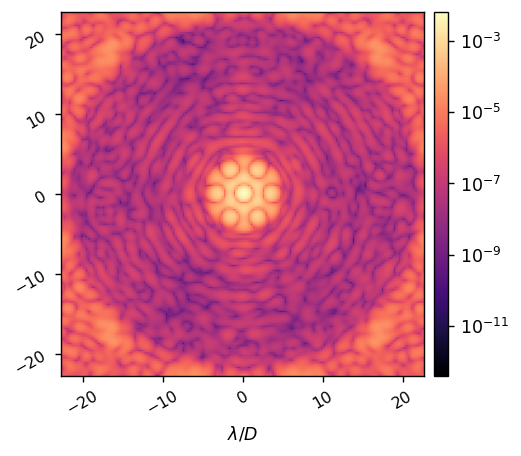

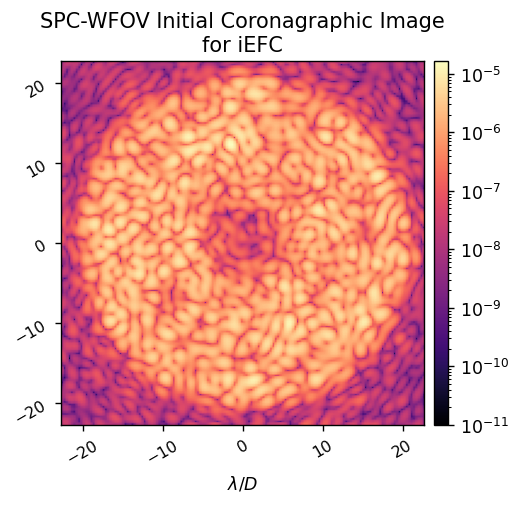

In [2]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=dm1_flat, dm2_ref=dm2_flat,
                                  )
# mode.det_rotation = 1
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im_nom = mode.snap()
imshow1(ref_im_nom, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

nonlin_model = copy.copy(mode)

# Create dark hole ROI to calibrate and control

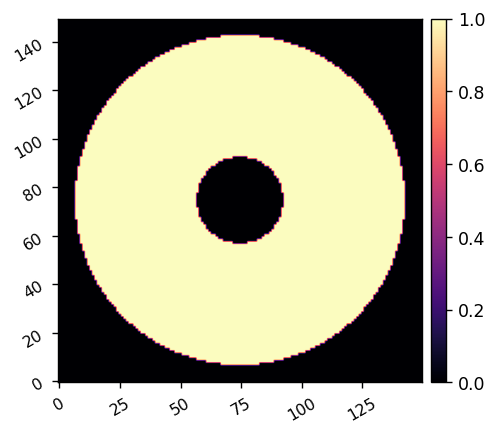

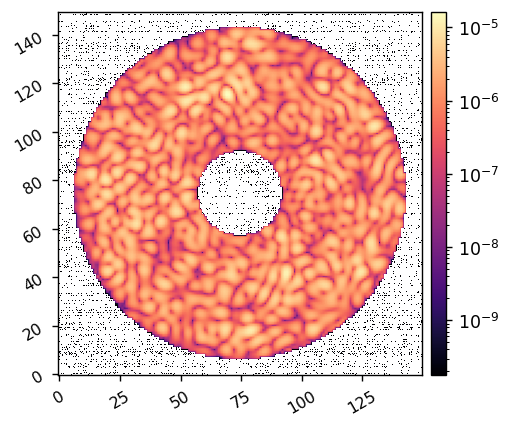

1.409806746664682e-06


In [3]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

imshow1(control_mask*ref_im_nom, lognorm=True)
mean_ni = xp.mean(ref_im_nom[control_mask])
print(mean_ni)

# Create calibration modes


(3608, 4608)


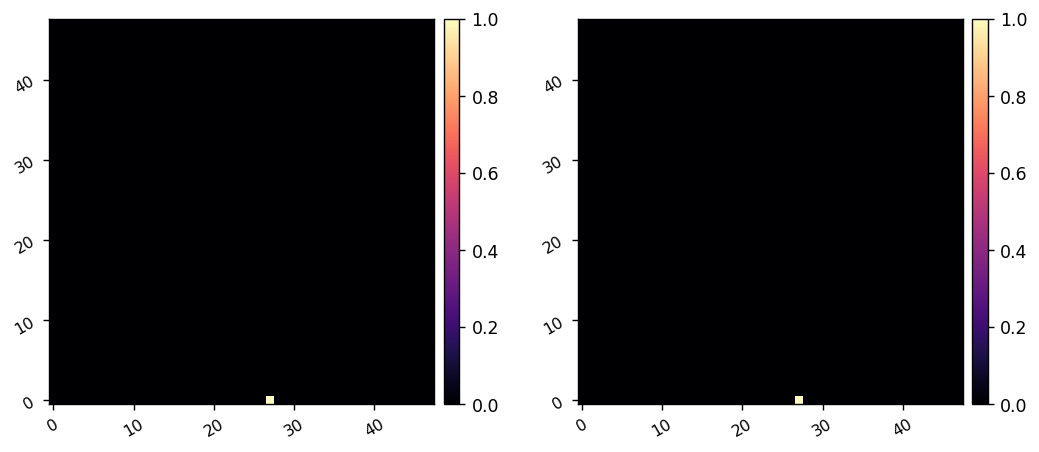

In [4]:
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


In [ ]:
reload(efc_2dm)

calib_amp = 1e-9

jac = efc_2dm.build_jacobian(mode, calib_amp, calib_modes, control_mask,
                             plot_responses=True,
                            )

# utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [ ]:
utils.save_fits(response_dir/f'efc_jacobian_{20231009}.fits', jac)

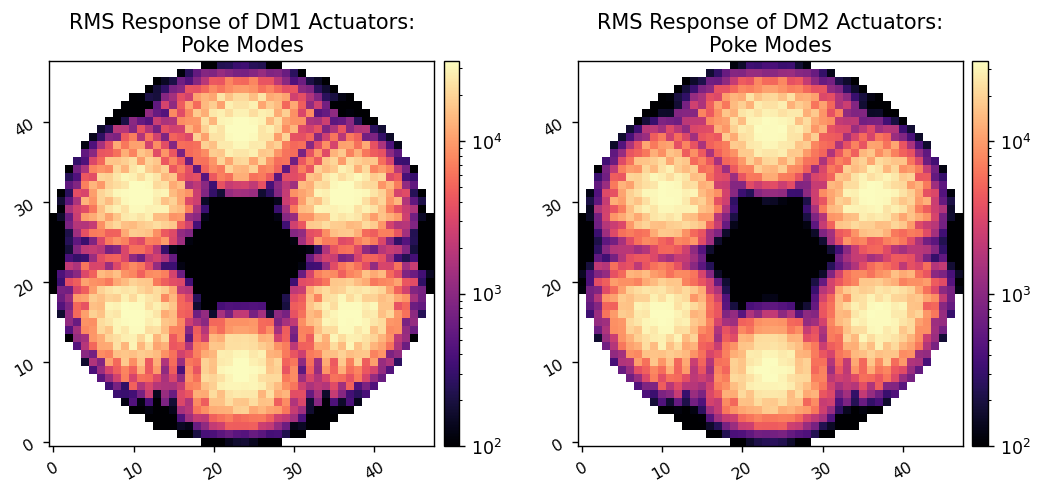

In [6]:
# date = 20231008
date = 20231013
date = 20231227
response_matrix = xp.array(fits.getdata(response_dir/f'efc_jacobian_{date}.fits'))

# date= 20231009
# response_matrix = xp.array(fits.getdata(response_dir/f'efc_jacobian_hadamard_{date}.fits'))

responses = response_matrix[::2] + 1j*response_matrix[1::2]

dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nPoke Modes', 'RMS Response of DM2 Actuators:\nPoke Modes',
        lognorm=True, vmin1=1e2, vmin2=1e2,
        )


# Perturb the model

In [175]:
mode.act_spacing * 48

<Quantity 47.5488 mm>

In [176]:
mode.act_spacing/47.5488 * 17.03414

<Quantity 0.35487792 mm>

In [7]:
shift = (mode.SPM.pixelscale*3*u.pix).to(u.mm)
display(shift.to(u.um))

shift_in_acts = mode.act_spacing/shift* (17.03414*u.mm/(46.3*u.mm))
print(1/shift_in_acts)

<Quantity 51.00041923 um>

0.13993817350452528


In [29]:
mode.SPM.pixelscale.to(u.mm/u.pix)

<Quantity 0.01700014 mm / pix>

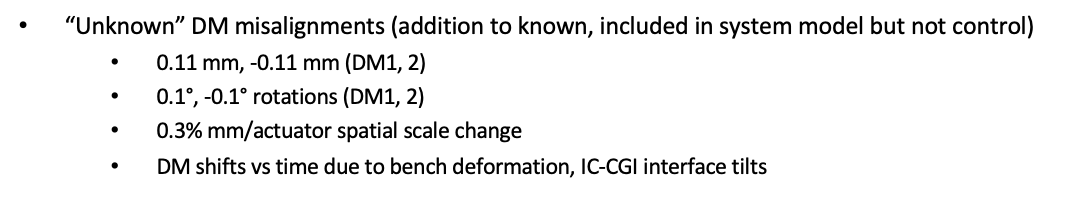


1.409806746664682e-06


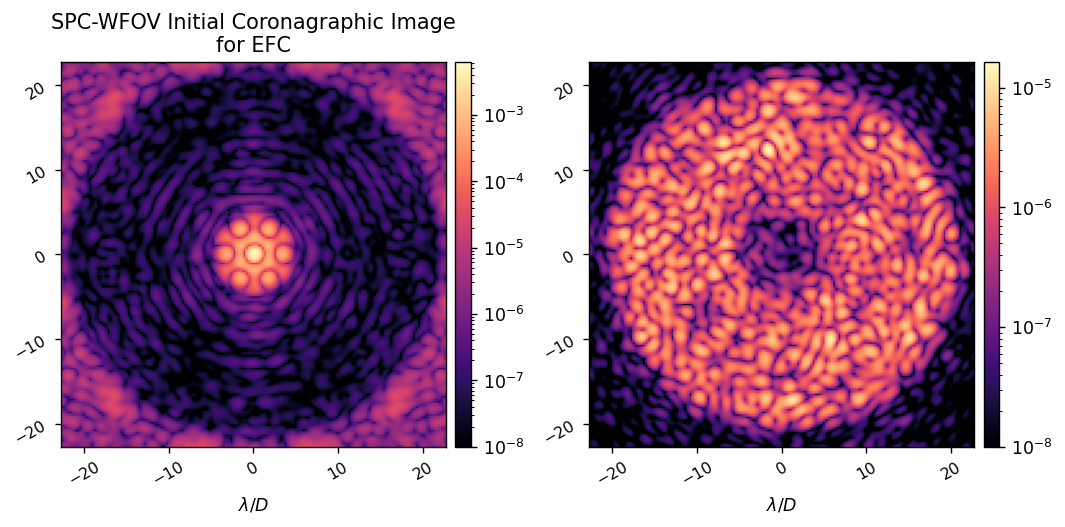

In [59]:
reload(cgi_phasec_poppy.cgi)
nonlin_model = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=dm1_flat, dm2_ref=dm2_flat,
                                  )

nonlin_model.use_fpm = False
ref_unocc_im = nonlin_model.snap()

nonlin_model.Imax_ref = ref_unocc_im.get().max()
nonlin_model.use_fpm = True

nonlin_ref_im = nonlin_model.snap()
print(xp.mean(nonlin_ref_im[control_mask]))
imshow2(ref_unocc_im, nonlin_ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor EFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin1=1e-8, vmin2=1e-8)


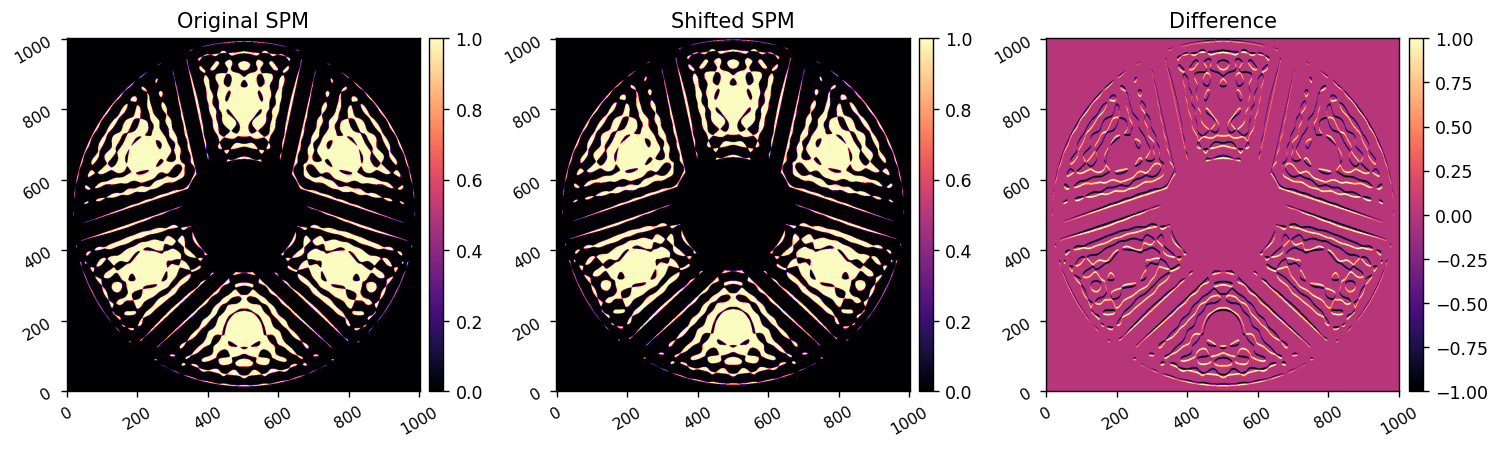

1.467286093489355e-06


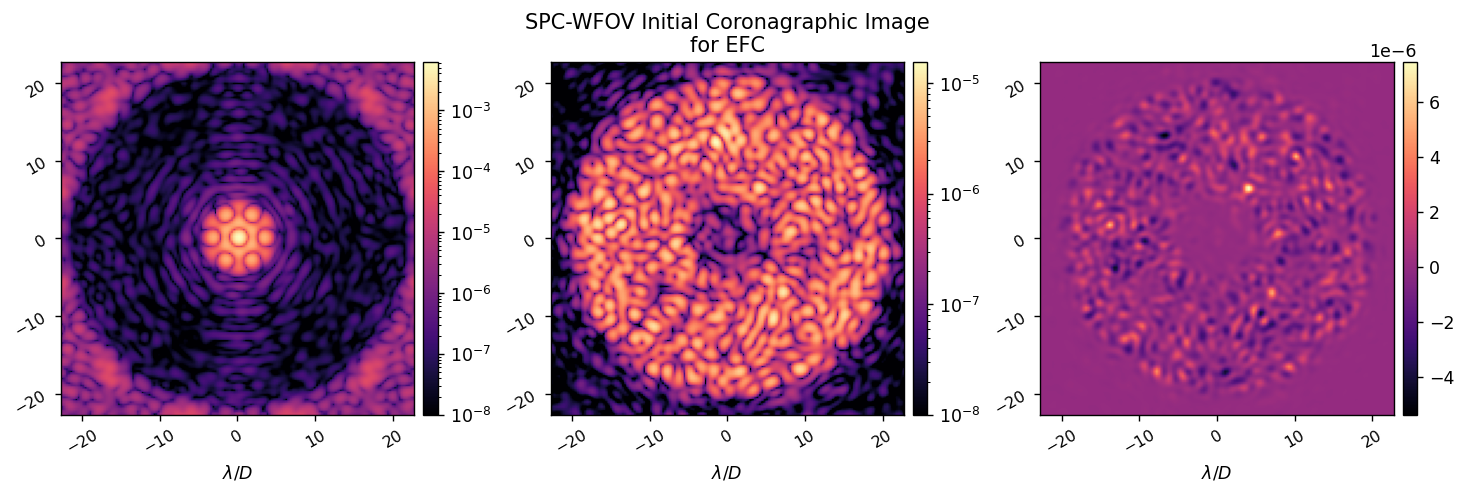

In [78]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=dm1_flat, dm2_ref=dm2_flat,
                                  dm1_shift=np.array([0.00011,0]),
                                  dm2_shift=np.array([-0.00011,0]),
                                #   dm1_rot = 0.1,
                                #   dm2_rot = -0.1,
                                  )


# perturb model by slightly shifting the SPM
original_spm = copy.copy(mode.SPM.amplitude)
spm_amp = mode.SPM.amplitude
# mode.SPM.amplitude = _scipy.ndimage.shift(spm_amp, (5,0))
mode.SPM.amplitude = _scipy.ndimage.shift(original_spm, (5,0))
imshow3(original_spm, mode.SPM.amplitude, original_spm-mode.SPM.amplitude,
        'Original SPM', 'Shifted SPM','Difference')

mode.use_fpm = False
ref_unocc_im = mode.snap()

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()

print(xp.mean(ref_im[control_mask]))
imshow3(ref_unocc_im, ref_im, ref_im - nonlin_ref_im, '', 'SPC-WFOV Initial Coronagraphic Image\nfor EFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm1=True, lognorm2=True, vmin1=1e-8, vmin2=1e-8)


In [238]:
xp.mean(ref_im[control_mask])

array(1.67829949e-06)

hyatt and marriott and hotel commonwealth

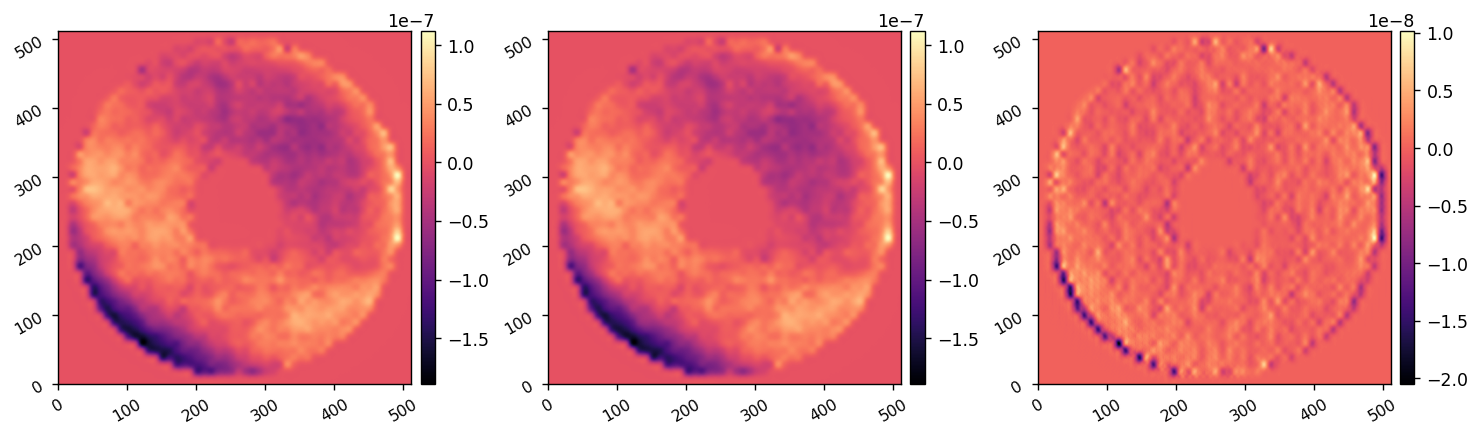

In [48]:
import poppy
wf = poppy.FresnelWavefront(beam_radius=25*u.mm, npix=512, oversample=1)

model_dm1 = nonlin_model.DM1.get_opd(wf)
actual_dm1 = mode.DM1.get_opd(wf)

imshow3(model_dm1, actual_dm1, model_dm1-actual_dm1)


In [113]:
mode.DM1.shift_x

0.00011

# Run EFC

In [79]:
mode.reset_dms()
nonlin_model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

# With DM and SPM shift

spm shift was (-5,0)


Beginning closed-loop EFC simulation.
	Running iteration 43/45.


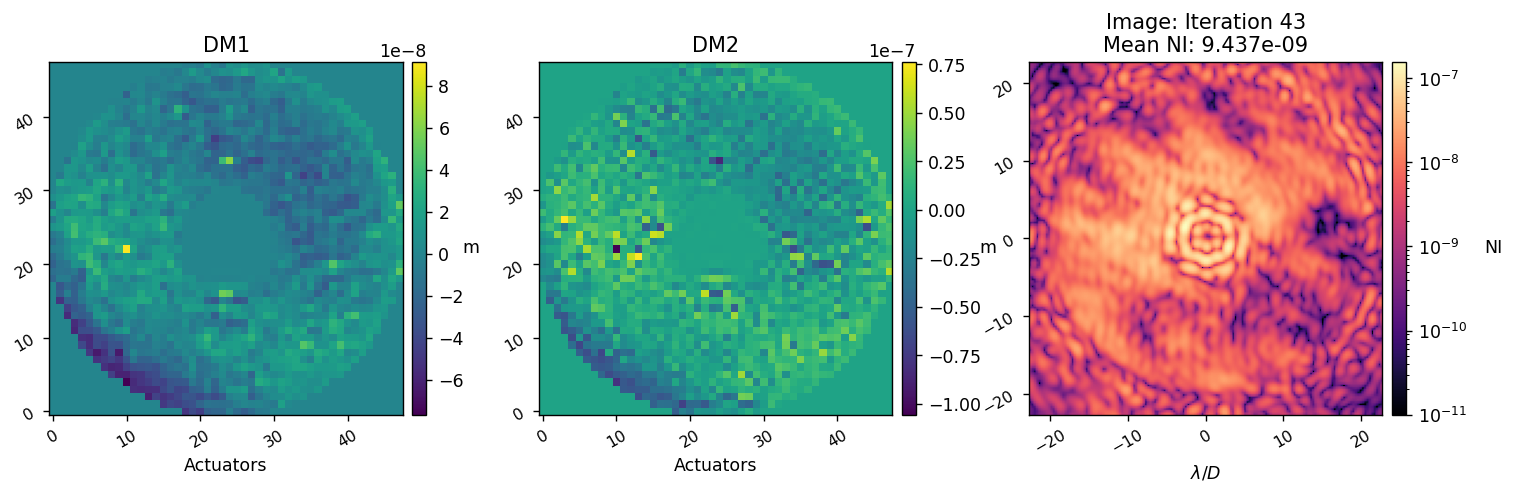

	Running iteration 44/45.


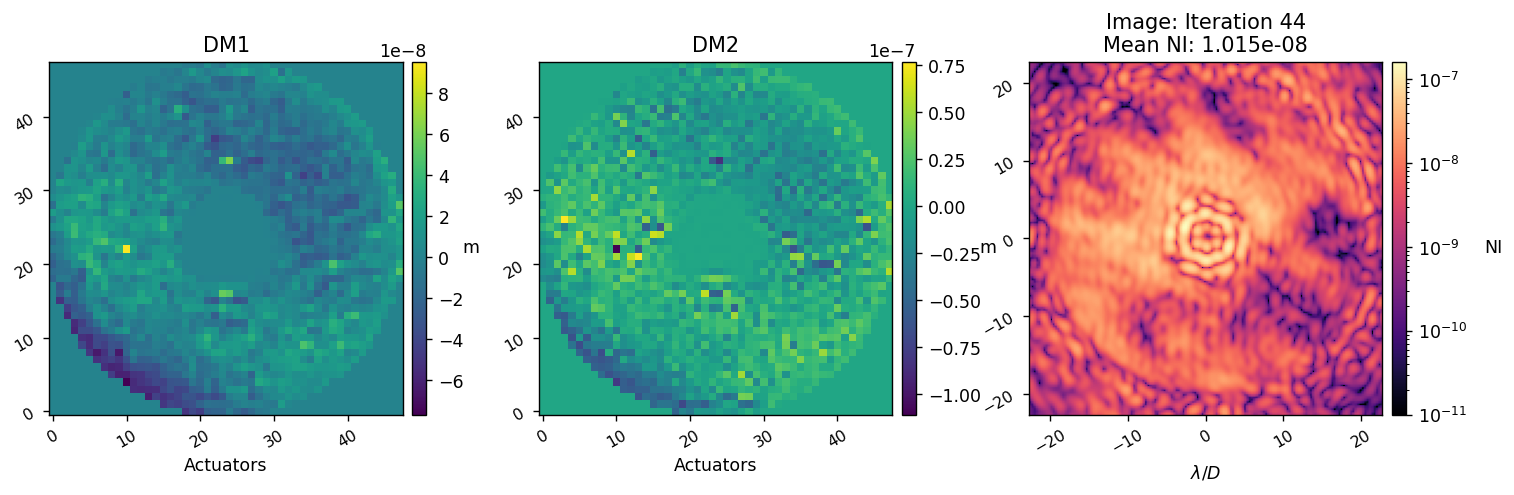

	Running iteration 45/45.


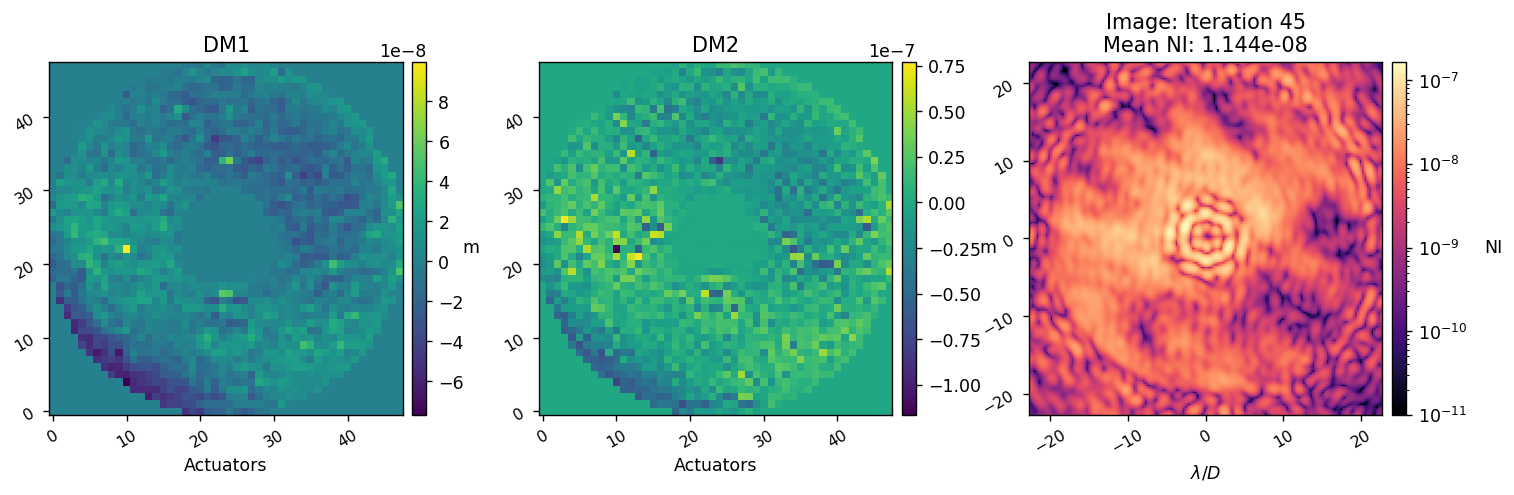

EFC completed in 4.005 sec.


In [57]:
reload(efc_2dm)

reg_fun = utils.beta_reg
reg_conds = -2.5
reg_conds = -3.5


images, dm1_commands, dm2_commands, regs = efc_2dm.run_efc_perfect(mode, 
                                                                response_matrix, 
                                                                reg_fun, reg_conds,
                                                                calib_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )

# With DM and SPM shift

spm shift was (5,0)


Beginning closed-loop EFC simulation.
	Running iteration 37/39.


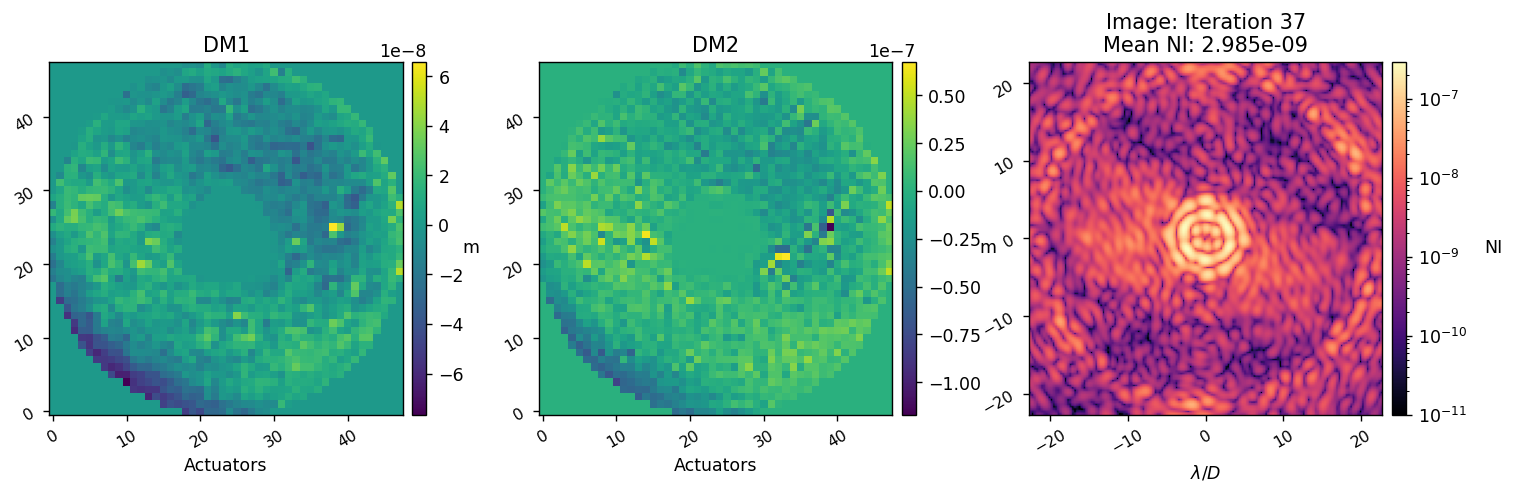

	Running iteration 38/39.


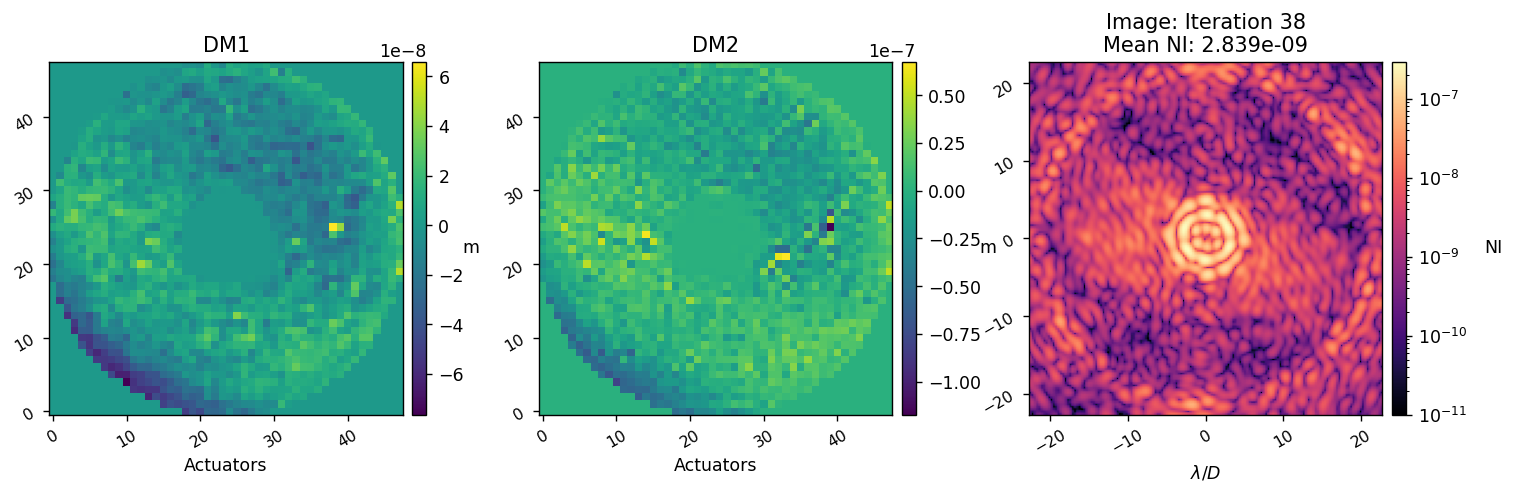

	Running iteration 39/39.


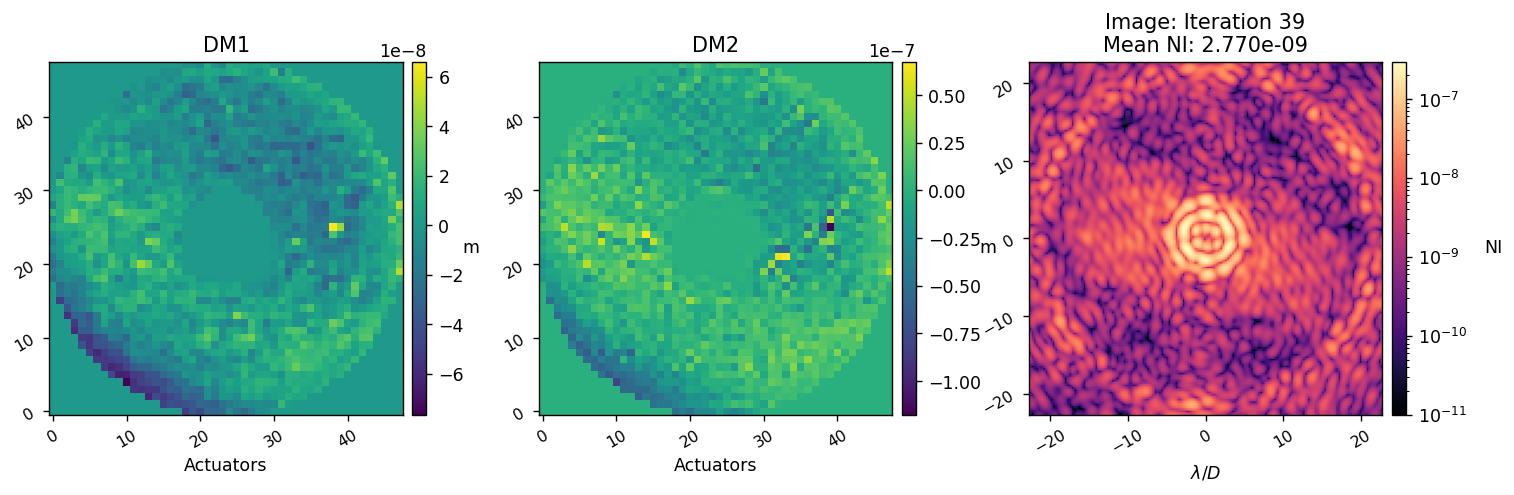

EFC completed in 4.246 sec.


In [92]:
reload(efc_2dm)

reg_fun = utils.beta_reg
reg_conds = -1.5
# reg_conds = -3.5


images, dm1_commands, dm2_commands, regs = efc_2dm.run_efc_perfect(mode, 
                                                                response_matrix, 
                                                                reg_fun, reg_conds,
                                                                calib_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )

# With just the SPM shift

Beginning closed-loop EFC simulation.
	Running iteration 37/39.


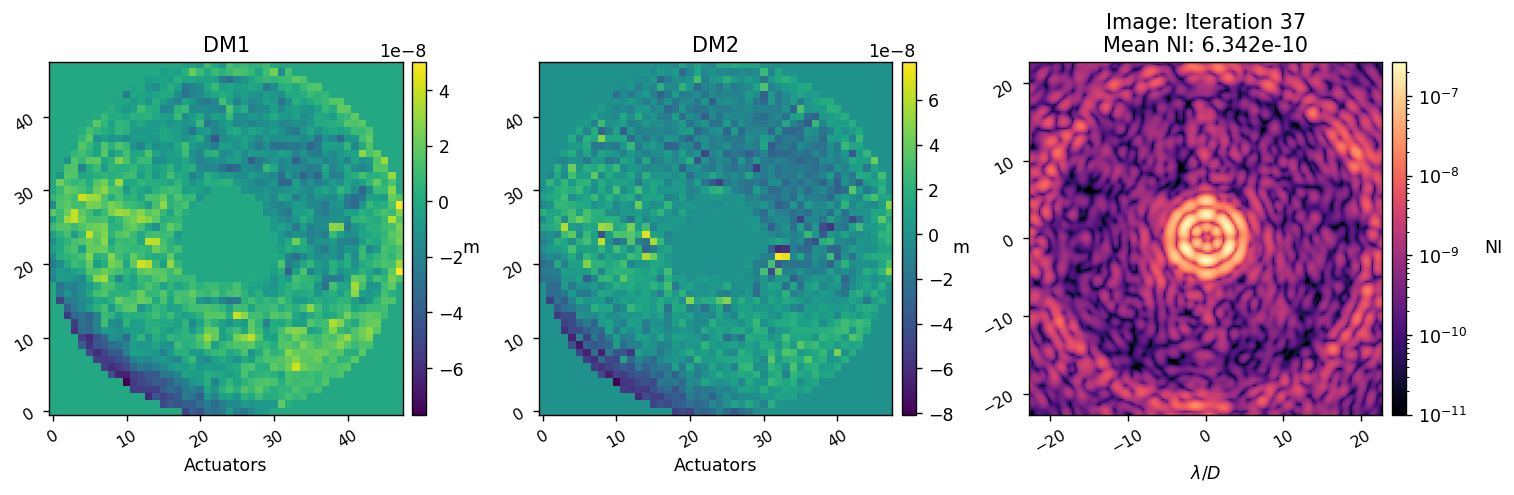

	Running iteration 38/39.


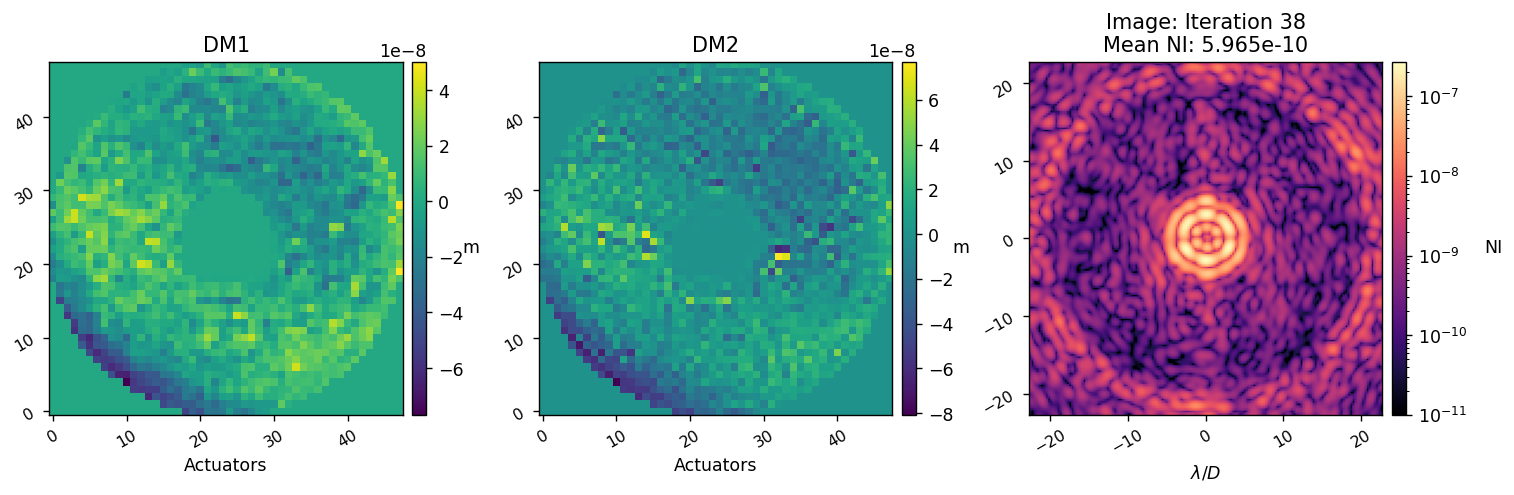

	Running iteration 39/39.


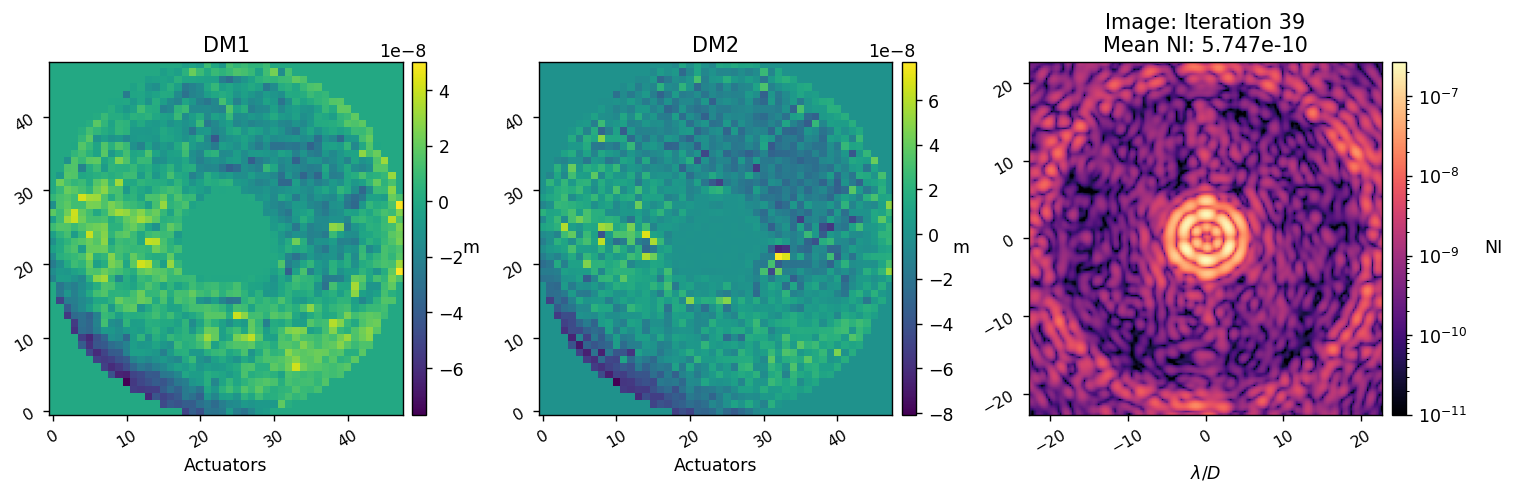

EFC completed in 4.206 sec.


In [77]:
reload(efc_2dm)

reg_fun = utils.beta_reg
reg_conds = -2.5
# reg_conds = -3.5

images, dm1_commands, dm2_commands, regs = efc_2dm.run_efc_perfect(mode, 
                                                                response_matrix, 
                                                                reg_fun, reg_conds,
                                                                calib_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )

# With just the DM shifts

Beginning closed-loop EFC simulation.
	Running iteration 22/24.


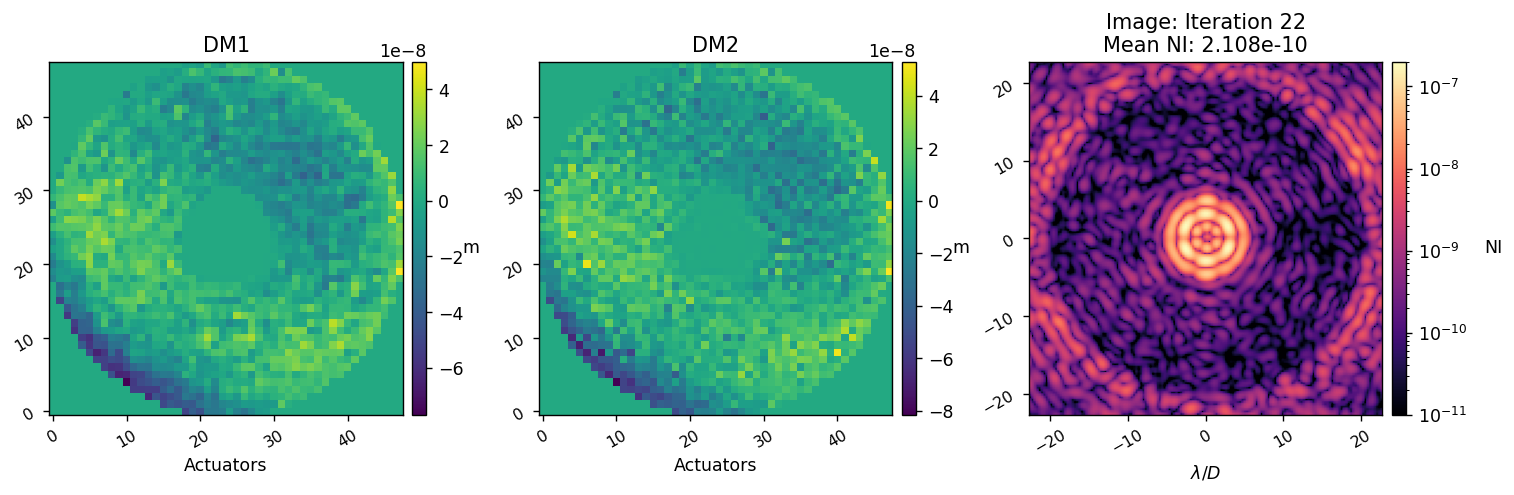

	Running iteration 23/24.


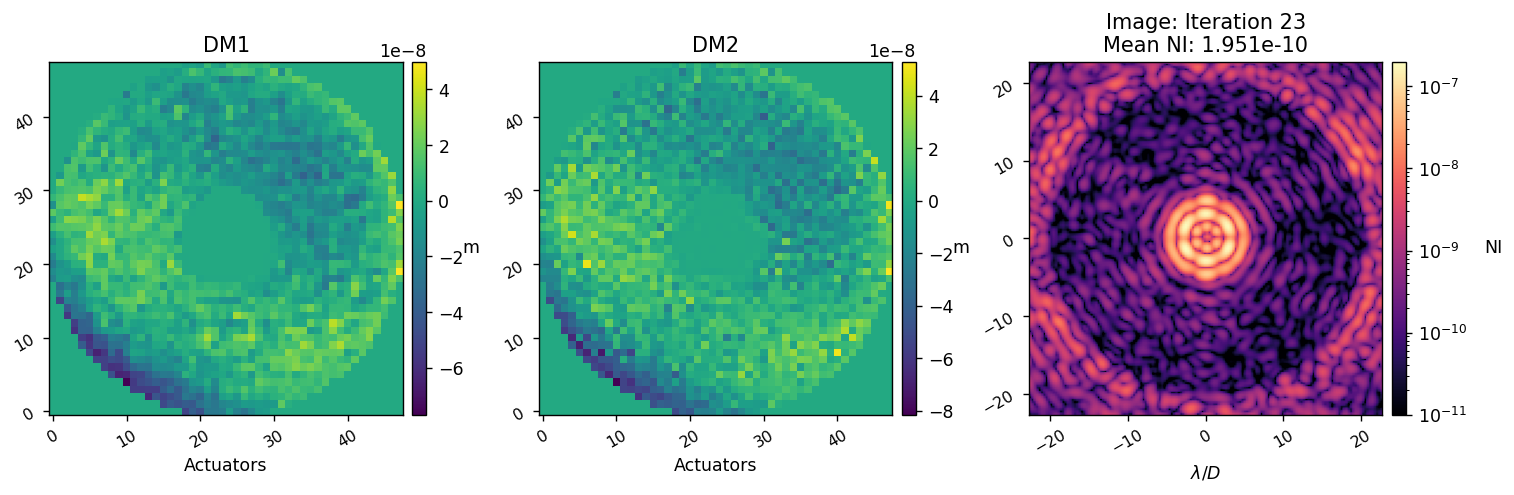

	Running iteration 24/24.


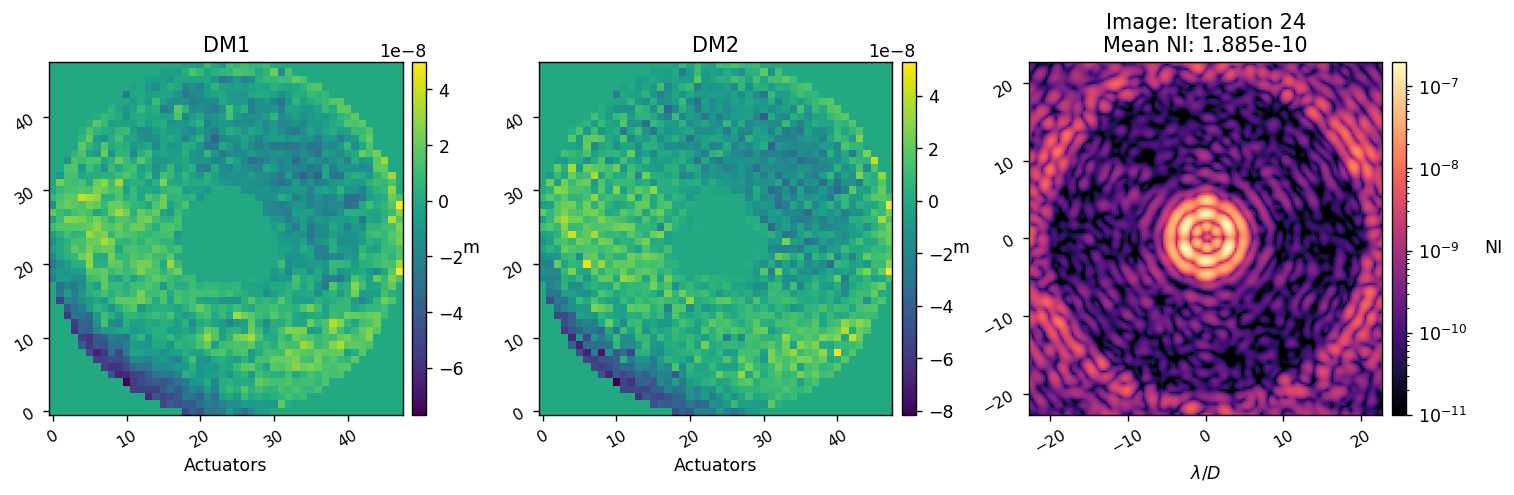

EFC completed in 4.160 sec.


In [ ]:
reload(efc_2dm)

reg_fun = utils.beta_reg
reg_conds = -2.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc_2dm.run_efc_perfect(mode, 
                                                                response_matrix, 
                                                                reg_fun, reg_conds,
                                                                calib_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )

Beginning closed-loop EFC simulation.
	Running iteration 22/24.


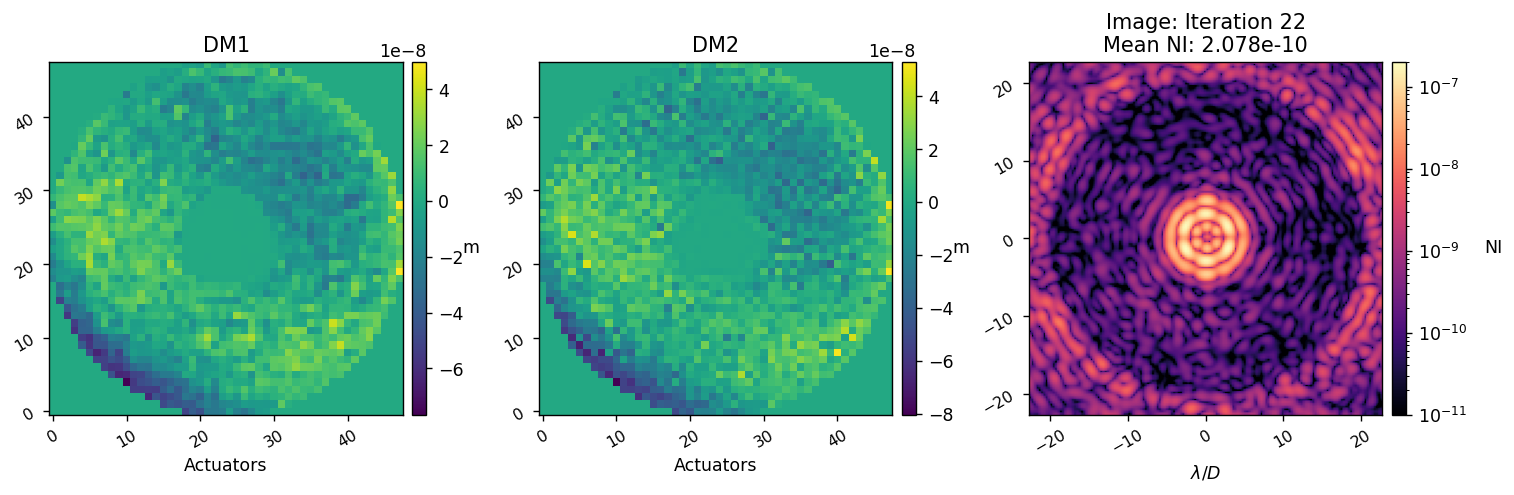

	Running iteration 23/24.


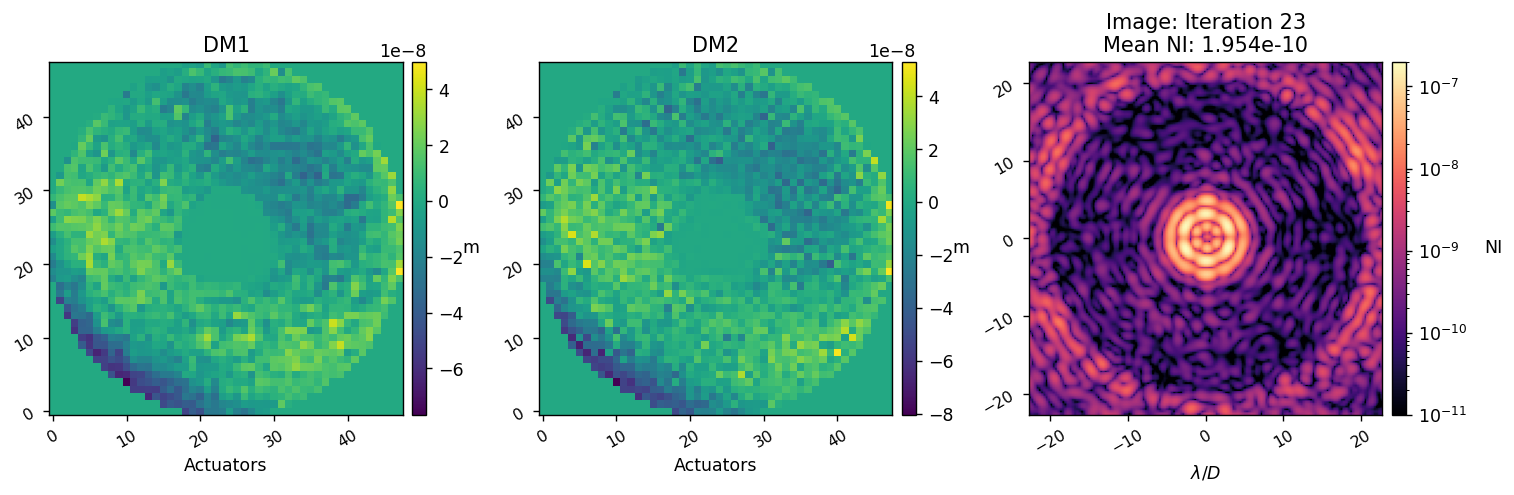

	Running iteration 24/24.


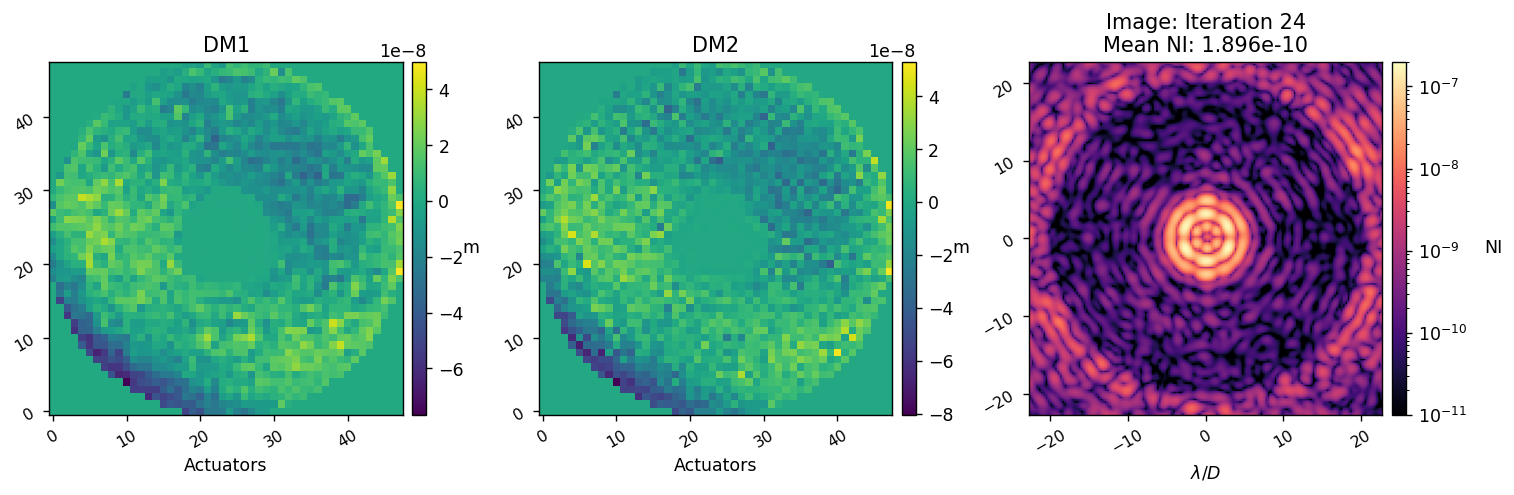

EFC completed in 4.035 sec.


In [143]:
reload(efc_2dm)

images, dm1_commands, dm2_commands, regs = efc_2dm.run_efc_perfect(mode, 
                                                                response_matrix, 
                                                                reg_fun, reg_conds,
                                                                calib_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )

In [28]:
date

20231013

In [29]:
utils.save_fits(response_dir/f'spc_wfov_825_efc_perturbed_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_825_efc_perturbed_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_825_efc_perturbed_images_{date}.fits', images)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_perturbed_dm1_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_perturbed_dm2_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_perturbed_images_20231013.fits


In [5]:
date = 20231013

In [9]:
images_ideal = fits.getdata(response_dir/f'spc_wfov_825_efc_hadamard_images_{date}.fits')

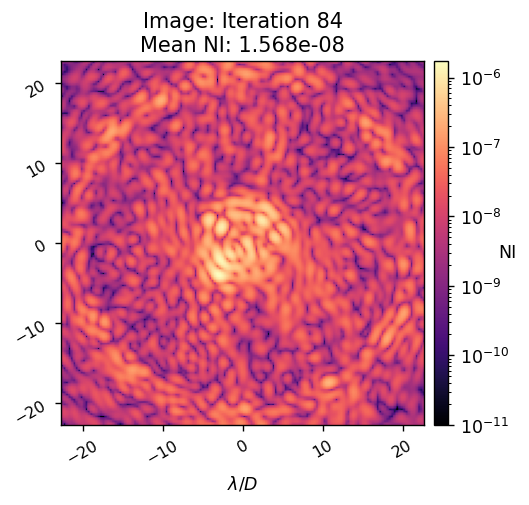

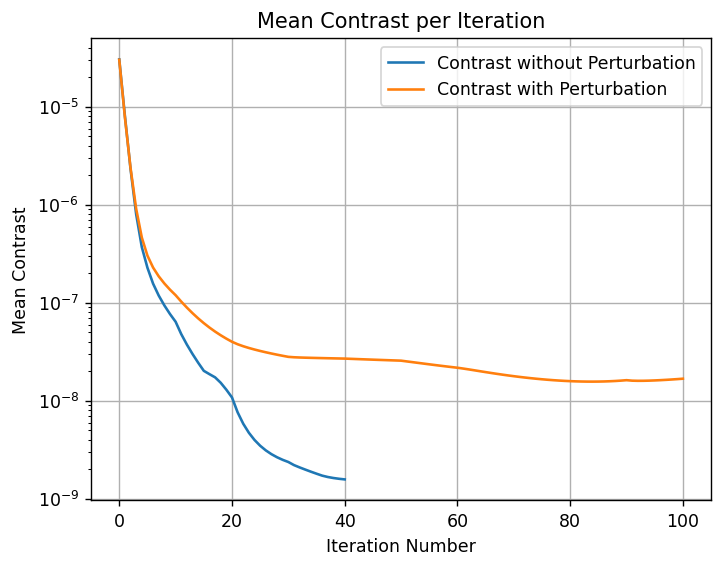

In [12]:
import imshows
reload(imshows)
from imshows import *
images = fits.getdata(response_dir/f'spc_wfov_825_efc_perturbed_images_{date}.fits')
mean_nis = np.zeros(len(images))
for i in range(len(images)):
    mean_nis[i] = np.mean(images[i][ensure_np_array(control_mask)])

mean_nis_ideal = []
for i in range(len(images_ideal)):
    mean_nis_ideal.append(np.mean(images_ideal[i][ensure_np_array(control_mask)]))

import matplotlib.pyplot as plt
plt.figure(dpi=125)
plt.semilogy(range(len(images_ideal)), mean_nis_ideal, label='Contrast without Perturbation')
plt.semilogy(range(len(images)), mean_nis, label='Contrast with Perturbation')
plt.grid()
plt.ylabel('Mean Contrast')
plt.xlabel('Iteration Number')
plt.title('Mean Contrast per Iteration')
plt.legend()

imin = np.argmin(mean_nis)
imshow1(images[imin], f'Image: Iteration {imin}\nMean NI: {mean_nis[imin]:.3e}', lognorm=True, 
        xlabel='$\lambda/D$', pxscl=mode.psf_pixelscale_lamD, vmin=1e-11, cbar_label='NI')